<a href="https://colab.research.google.com/github/BadrOuannas/POO/blob/master/HmmDigitRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [0]:
import numpy as np
import math 
import sympy as sym
import scipy as scipy 
from scipy.io.wavfile import write
import librosa 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import librosa.display 
import IPython.display as ipd
from scipy.special import logsumexp as LOGSUMEXPONENT
from sklearn.metrics import accuracy_score

# Data handling

In [0]:
def read_data() :
    data = np.load('lab2_data.npz', allow_pickle=True)['data']
    return data

In [0]:
def read_example_data() :
    example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
    return example

In [0]:
def read_phoneHMMs() :
  phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
  phoneHMMs_oneSpeaker = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
  return phoneHMMs_all, phoneHMMs_oneSpeaker

In [0]:
def play_audio_Ipython(song = "example.wav") :
    return ipd.Audio(song)

In [0]:
data = read_data() 

In [8]:
data[0]

{'digit': 'o',
 'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav',
 'gender': 'man',
 'lmfcc': array([[  64.7657709 ,  -65.84854216,   96.90766069, ...,  -19.82632821,
           11.63249931,  159.50790488],
        [  57.72402791,  -79.93732698,  105.80893583, ...,  -11.84501965,
          109.29701349,  138.79176124],
        [  62.16944867, -121.81014369,   61.89899215, ...,   13.28252915,
         -127.7140298 , -128.75563442],
        ...,
        [ 190.29491187,   97.34488369,  175.61357289, ...,  -62.63035172,
          138.96640354,   82.95734165],
        [ 201.37123403,   80.09496653,   50.98133557, ...,  219.16711476,
           94.41131525, -100.10312668],
        [ 194.17067167,   70.85205455,   40.456538  , ...,   -3.81053312,
          143.83615904,  -42.56212766]]),
 'repetition': 'a',
 'samples': array([-2, -1, -3, ..., 10,  8,  5], dtype=int16),
 'samplingrate': 20000,
 'speaker': 'bm'}

In [9]:
samplerate = data[0]['samplingrate']
signal = data[0]['samples']
write("example.wav", samplerate, signal)
play_audio_Ipython("example.wav")

# Functions implementation

## 4. Concatenating HMMs

### HMMs concatenation and phonemes

Each words or digits is composed of phonemes for instance the digit 1 can be described as prondict['1'] = ['w', 'ah', 'n']. Below is the phonemes of all the words 

In [0]:
prondict = {} 
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']


Each words is modeled as a Hmm of 3 states with Gaussian emision. But a extra state is added in order to simplify concatenation. This HMM is called the phonemen HMM model 

$state_{probability} = \begin{bmatrix} \pi_0 & \pi_1 & \pi_2 & \pi_3  \end{bmatrix}$ \\
$transition_{matrix} = \begin{bmatrix}
a_{00} & a_{01} & a_{02} &  a_{03}   \\
a_{10} & a_{11} & a_{12} &  a_{13}   \\
a_{20} & a_{21} & a_{22} &  a_{23}   \\
0      & 0      & 0      &  1 
 \end{bmatrix}$ \\

 $ emission_{probability} = B_{j}(X) = p(X|S_{t} = j) \sim \mathcal{N}(X | \mu_i, \Sigma_i) $

We have three states, so :
$\mu_{s1} = \begin{bmatrix} \mu_0 & \mu_1, & \dots &, \mu_{12}  \end{bmatrix}$ 

$\Sigma_{s1} = \begin{bmatrix} 
    \lambda_0 & 0 & \dots  & 0 \\
    0 & \lambda_1 & \dots  & 0 \\
    \vdots & \vdots & \ddots \\
    0 & 0  & \dots   & \lambda_{12}
    \end{bmatrix}$

$\mu_{s2} = \begin{bmatrix} \mu_0 & \mu_1, & \dots &, \mu_{12}  \end{bmatrix}$ 

$\Sigma_{s2} = \begin{bmatrix} 
    \lambda_0 & 0 & \dots  & 0 \\
    0 & \lambda_1 & \dots  & 0 \\
    \vdots & \vdots & \ddots \\
    0 & 0  & \dots   & \lambda_{12}
    \end{bmatrix}$

$\mu_{s3} = \begin{bmatrix} \mu_0 & \mu_1, & \dots &, \mu_{12}  \end{bmatrix}$ 

$\Sigma_{s3} = \begin{bmatrix} 
    \lambda_0 & 0 & \dots  & 0 \\
    0 & \lambda_1 & \dots  & 0 \\
    \vdots & \vdots & \ddots \\
    0 & 0  & \dots   & \lambda_{12}
    \end{bmatrix}$


Combining/concatenating all the phonemes HMM models for a word for instance prondict['z'] = ['z', 'iy', 'r', 'ow'] gives us the word models for digit 'z'


The first to implement is the function for concaneting two HMMs together. 
Hmm1 : \\
$\pi = \begin{bmatrix} \pi_0 & \pi_1 & \pi_2 & \pi_3  \end{bmatrix}$ \\
$\pi = \begin{bmatrix}
a_{00} & a_{01} & a_{02} &  a_{03}   \\
a_{10} & a_{11} & a_{12} &  a_{13}   \\
a_{20} & a_{21} & a_{22} &  a_{23}   \\
0      & 0      & 0      &  1 
 \end{bmatrix}$ \\

 Hmm2 : \\
$P = \begin{bmatrix} \rho_0 & \rho_1 & \rho_2 & \rho_3  \end{bmatrix}$ \\
$\pi = \begin{bmatrix}
b_{00} & b_{01} & b_{02} &  b_{03}   \\
b_{10} & b_{11} & b_{12} &  b_{13}   \\
b_{20} & b_{21} & b_{22} &  b_{23}   \\
0      & 0      & 0      &  1 
 \end{bmatrix}$ \\

 Concateneting the two gives : \\
 $\pi_{concat} = \begin{bmatrix} \pi_0 & \pi_1 & \pi_2 & \pi_3\rho_0 & \pi_3\rho_1 & \pi_3\rho_2 & \pi_3\rho_3  \end{bmatrix}$ \\


$A_{concat} = \begin{bmatrix}
a_{00} & a_{01} & a_{02} &  a_{03}\rho_0 &  a_{03}\rho_1 & a_{03}\rho_2 &  a_{03}\rho_3    \\
a_{10} & a_{11} & a_{12} &  a_{13}\rho_0 & a_{03}\rho_1 & a_{03}\rho_2 &  a_{03}\rho_3    \\
a_{20} & a_{21} & a_{22} &  a_{23}\rho_0 &  a_{03}\rho_1 & a_{03}\rho_2 &  a_{03}\rho_3    \\
0 & 0 & 0 & b_{00} & b_{01} & b_{02} &  b_{03}   \\
0 & 0 & 0 & b_{10} & b_{11} & b_{12} &  b_{13}   \\
0 & 0 & 0 & b_{20} & b_{21} & b_{22} &  b_{23}   \\
0 & 0 & 0 & 0      & 0      & 0      &  1 
 \end{bmatrix}$ \\




In [0]:
def concatTwoHMMs_SYMBOLIC(A_state_prob, A_transition, B_state_prob, B_transition):
    
    new_length = len(A_state_prob) + len(B_state_prob) - 1
    new_state_prob_A = np.ones(new_length)
    new_state_prob_B = np.ones(new_length)
    new_state_prob_A = np.array(new_state_prob_A, dtype=np.object)
    new_state_prob_B = np.array(new_state_prob_B, dtype=np.object)
    
    # Create the new state probability
    new_state_prob_B[len(A_state_prob)-1:] = B_state_prob
    new_state_prob_A[:-(len(B_state_prob) - 1)] = A_state_prob
    new_state_prob_A[len(A_state_prob):] = A_state_prob[-1]

    new_state_prob_AB = new_state_prob_A * new_state_prob_B
    
    # Create the new transition matrix A 
    A_transition_concat = np.zeros((new_length,new_length))
    row_A, col_A = np.shape(A_transition)
    A_transition_concat = np.array(A_transition_concat, dtype=np.object)
    A_transition_concat[:row_A-1,:col_A] = A_transition[:row_A-1,:]


    form = np.shape(A_transition_concat[:row_A-1,col_A:])
    if 1 in form : 
        A_transition_concat[:row_A-1,col_A:] = np.reshape(A_transition[:row_A-1,-1], form) 
    else :
        temp_vec = np.repeat(A_transition[:row_A-1,-1], len(B_state_prob) - 1)
        temp_vec_reshape = np.reshape( temp_vec,(len(A_state_prob) - 1, len(B_state_prob) - 1))
        A_transition_concat[:row_A-1,col_A:] = np.reshape( temp_vec,(len(A_state_prob) - 1, len(B_state_prob) - 1))
        

    A_transition_concat[:row_A-1,] = A_transition_concat[:row_A-1,] * new_state_prob_B
    A_transition_concat[row_A-1:,col_A-1:] = B_transition

    return new_state_prob_AB, A_transition_concat
    

In [0]:
def concatTwoHMMs(hmm1, hmm2):
    
    A_state_prob = hmm1['startprob']
    A_transition = hmm1['transmat']
    B_state_prob = hmm2['startprob']
    B_transition = hmm2['transmat']
    
    new_length = len(A_state_prob) + len(B_state_prob) - 1
    new_state_prob_A = np.ones(new_length)
    new_state_prob_B = np.ones(new_length)
    
    # Create the new state probability
    new_state_prob_B[len(A_state_prob)-1:] = B_state_prob
    new_state_prob_A[:-(len(B_state_prob) - 1)] = A_state_prob
    new_state_prob_A[len(A_state_prob):] = A_state_prob[-1]

    new_state_prob_AB = new_state_prob_A * new_state_prob_B
    
    # Create the new transition matrix A 
    A_transition_concat = np.zeros((new_length,new_length))
    row_A, col_A = np.shape(A_transition)
    A_transition_concat[:row_A-1,:col_A] = A_transition[:row_A-1,:]
    
    form = np.shape(A_transition_concat[:row_A-1,col_A:])
    if 1 in form : 
        A_transition_concat[:row_A-1,col_A:] = np.reshape(A_transition[:row_A-1,-1], form) 
    else :
        #print("np.shape(A_transition_concat[:row_A-1,col_A:]) : ", np.shape(A_transition_concat[:row_A-1,col_A:]))

        temp_vec = np.repeat(A_transition[:row_A-1,-1], len(B_state_prob) - 1)
        temp_vec_reshape = np.reshape( temp_vec,(len(A_state_prob) - 1, len(B_state_prob) - 1))
        #print("np.shape(A_transition[:row_A-1,-1]) : ", np.shape(temp_vec_reshape))
        A_transition_concat[:row_A-1,col_A:] = np.reshape( temp_vec,(len(A_state_prob) - 1, len(B_state_prob) - 1))
        #A_transition_concat[:row_A-1,col_A:] = A_transition_concat[:row_A-1,col_A:].T
        
    A_transition_concat[:row_A-1,] = A_transition_concat[:row_A-1,] * new_state_prob_B
    A_transition_concat[row_A-1:,col_A-1:] = B_transition
    
    A_means = hmm1['means']
    B_means = hmm2['means']
    
    A_cov = hmm1['covars']
    B_cov = hmm2['covars']
    #print("A_cov = ", A_cov)
    #print("B_cov = ", B_cov)
    AB_means = np.concatenate((A_means, B_means))
    AB_cov = np.concatenate((A_cov, B_cov))
    #print()
    #print("combined_cov = ", AB_cov)
    
    combinedHmms = {'name': hmm1['name'] + '_' +  hmm2['name'], 
                    'startprob': new_state_prob_AB, 
                    'transmat': A_transition_concat, 
                    'means':AB_means, 
                    'covars':AB_cov}
    
    #return new_state_prob_AB, A_transition_concat
    return combinedHmms
    

In [0]:
def concatHMMs(hmmmodels, namelist):
    """ Concatenates HMM models in a left to right manner

    Args:
       hmmmodels: dictionary of models indexed by model name. 
       hmmmodels[name] is a dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
       namelist: list of model names that we want to concatenate

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)

    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models:
         startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models

    Example:
       wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
    """
    concat = hmmmodels[namelist[0]]
    for idx in range(1,len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])
    return concat

In [0]:
def pronounciation_dictionary() :
    
    def isolated_digit(prondict) :
        isolated = {}
        for digit in prondict.keys():
            isolated[digit] = ['sil'] + prondict[digit] + ['sil']
        return isolated
    
    prondict = {} 
    prondict['o'] = ['ow']
    prondict['z'] = ['z', 'iy', 'r', 'ow']
    prondict['1'] = ['w', 'ah', 'n']
    prondict['2'] = ['t', 'uw']
    prondict['3'] = ['th', 'r', 'iy']
    prondict['4'] = ['f', 'ao', 'r']
    prondict['5'] = ['f', 'ay', 'v']
    prondict['6'] = ['s', 'ih', 'k', 's']
    prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
    prondict['8'] = ['ey', 't']
    prondict['9'] = ['n', 'ay', 'n']
    
    return prondict, isolated_digit(prondict)

Construtiong thw word model for each phonemes HMM using phoneHMMs, isolated (isolated is prondict + silences)

In [0]:
def word_models(phoneHMMs, isolated) :
    wordHMMs = {}
    for digit in isolated.keys():
        wordHMMs[digit] = concatHMMs(phoneHMMs, isolated[digit])
    return wordHMMs

## 5. HMM Likelihood and Recognition

### 5.1 Gaussian emission probabilities

In [0]:
def log_multivariate_normal_density_diag(X, means, covars):
    """Compute Gaussian log-density at X for a diagonal model

    Args:
        X: array like, shape (n_observations, n_features)
        means: array like, shape (n_components, n_features)
        covars: array like, shape (n_components, n_features)

    Output:
        lpr: array like, shape (n_observations, n_components)
    From scikit-learn/sklearn/mixture/gmm.py
    """
    n_samples, n_dim = X.shape
    lpr = -0.5 * (n_dim * np.log(2 * np.pi) + np.sum(np.log(covars), 1)
                  + np.sum((means ** 2) / covars, 1)
                  - 2 * np.dot(X, (means / covars).T)
                  + np.dot(X ** 2, (1.0 / covars).T))
    return lpr

### 5.2 Forward Algorithm

In [0]:
def forward(log_emlik, log_startprob, log_transmat):
    
    emission_obs = log_emlik
    
    T , n_states = np.shape(log_emlik)
    log_transmat = log_transmat[:n_states,:n_states]
    log_startprob = log_startprob[:n_states]

    log_startprob_init = log_startprob + emission_obs[0,:]
    alphas = np.zeros((T, n_states))
    alphas[0,:] = log_startprob + emission_obs[0,:]
    #alphas = np.zeros((T, n_states))
    for t in range(1, T) :
        for i in range(n_states) : 
            alphas[t,i] = LOGSUMEXPONENT(alphas[t-1,:] + log_transmat[:,i]) + emission_obs[t,i]
            #alphas[t,:] = logsumexp(alphas[t-1,:] + log_transmat[:,i]) + np.log(emission_obs[t,:])
    return alphas, LOGSUMEXPONENT(alphas[-1,:])

In [0]:
def score_likelihood(X, wordHMMs) :
    """
    X : is the observation from the lmfcc features Nframes X Ncoeeficients
        X = example['lmfcc'] 
    wordHMMs : is the word models of all the digits 
                ['o', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    """
    keys = list(wordHMMs.keys())
    wordsLogLikelihood = []
    
    for i in range(len(keys)) :
        covars = wordHMMs[keys[i]]['covars']
        means = wordHMMs[keys[i]]['means']
        float_epsilon = 2.22e-1000
        startprob = wordHMMs[keys[i]]['startprob'] + float_epsilon
        transmat = wordHMMs[keys[i]]['transmat'] + float_epsilon

        obsloglik_implemented = log_multivariate_normal_density_diag(X, means, covars)
        alphas, logLikelihood = forward(obsloglik_implemented, startprob, transmat)
        
        wordsLogLikelihood.append(logLikelihood)
        
    arg_max = np.argmax(wordsLogLikelihood)
    return wordsLogLikelihood, arg_max, keys[arg_max]

def evaluate_models_data(data, wordHMMs) :
    digits = []
    pred_digits = []
    genders = []
    for data_element in  data :
        digit = data_element['digit']
        X = data_element['lmfcc']
        gender = data_element['gender']
        digits.append(digit)
        genders.append(gender)
        wordsLogLikelihoods, index_digit, letter_digit  = score_likelihood(X, wordHMMs) 
        pred_digits.append(letter_digit)
        
    acc = accuracy_score(digits, pred_digits)
    print("accuracy : ", acc)
    print(genders)
    print(digits)
    print(pred_digits)
    return genders, digits, pred_digits, acc

### 5.1 Viterbi Approximation 

In [0]:
from collections import deque

def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """
    N, M = log_emlik.shape
    
    # initialization
    viterbi_loglik = np.zeros((N, M))
    memo_path = np.zeros((N, M), dtype=int)
    viterbi_loglik[0,:] = log_startprob[:-1] + log_emlik[0, :]
    
    # induction 
    for i in range(1, N):
        viterbi_loglik[i, :] = np.max(viterbi_loglik[i-1, :] + log_transmat[:-1, :-1].T, 1) + log_emlik[i, :]
        memo_path[i, :] = np.argmax(viterbi_loglik[i-1, :] + log_transmat[:-1, :-1].T, 1)

    # backtracking
    if forceFinalState:
        lastState = M-1
    else:
        lastState = np.argmax(memo_path[-1, :])

    viterbi_path = deque()
    viterbi_path.append(lastState)

    for i in range(N-2, -1, -1):
        viterbi_path.appendleft(memo_path[i+1, viterbi_path[0]])    

    return max(viterbi_loglik[-1, :]), viterbi_path

### 5.1 Backward Algorithm 

In [0]:
def  backward(log_emlik, log_startprob, log_transmat):
    alphas, logLikelihood = forward(log_emlik, log_startprob, log_transmat)
    
    emission_obs = log_emlik
    log_startprob = log_startprob
    log_transmat = log_transmat
    
    T , n_states = np.shape(log_emlik)
    log_transmat = log_transmat[:n_states,:n_states]
    log_startprob = log_startprob[:n_states]
    
    betas = np.zeros((T, n_states))
    print("shape(betas) : ", np.shape(betas))
    for t in range(T-2, -1, -1):
        for i in range(n_states) : 
            betas[t,i] = LOGSUMEXPONENT(betas[t+1,:] + log_transmat[i,:] + emission_obs[t+1,:] ) #(71, 9)

    likelihood1 = LOGSUMEXPONENT(betas[0,:] + log_startprob + log_emlik[0,:])
    likelihood2 = LOGSUMEXPONENT(betas[0,:] + alphas[0,:])
    #print("likelihood1 =  ", likelihood1)
    #print("likelihood2 =  ", likelihood2)
    return betas, likelihood1

## 6 HMM Retraining (emission probability distributions) [TODO]

### 6.1 State posterior probabilities

In [0]:
def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """
    return log_alpha + log_beta - LOGSUMEXPONENT(log_alpha[-1, :])

### 6.2 Retraining the emission probability distributions [**TODO**]

# Functions demonstations and testing

## HMMs concatenations

### Example 1 (Symbolic version [see pdf])

In [0]:
pi0, pi1, pi2, pi3 = sym.symbols('pi0, pi1, pi2, pi3')
rho0, rho1, rho2, rho3 = sym.symbols('rho0, rho1, rho2, rho3')
A_state_prob = np.array([pi0, pi1, pi2, pi3])
B_state_prob = np.array([rho0, rho1, rho2, rho3])

a00, a01, a02, a03 = sym.symbols('a00, a01, a02, a03')
a10, a11, a12, a13 = sym.symbols('a10, a11, a12, a13')
a20, a21, a22, a23 = sym.symbols('a20, a21, a22, a23')
a30, a31, a32, a33 = sym.symbols('0, 0, 0, 1')
A_transition = np.array([
    [a00, a01, a02, a03 ],
    [a10, a11, a12, a13],
    [a20, a21, a22, a23],
    [a30, a31, a32, a33]
])

b00, b01, b02, b03 = sym.symbols('b00, b01, b02, b03')
b10, b11, b12, b13 = sym.symbols('b10, b11, b12, b13')
b20, b21, b22, b23 = sym.symbols('b20, b21, b22, b23')
b30, b31, b32, b33 = sym.symbols('0, 0, 0, 1')
B_transition = np.array([
    [b00, b01, b02, b03],
    [b10, b11, b12, b13],
    [b20, b21, b22, b23],
    [b30, b31, b32, b33]
])

In [63]:
A_state_prob 

array([pi0, pi1, pi2, pi3], dtype=object)

In [64]:
A_transition

array([[a00, a01, a02, a03],
       [a10, a11, a12, a13],
       [a20, a21, a22, a23],
       [0, 0, 0, 1]], dtype=object)

In [65]:
B_state_prob 

array([rho0, rho1, rho2, rho3], dtype=object)

In [66]:
B_transition

array([[b00, b01, b02, b03],
       [b10, b11, b12, b13],
       [b20, b21, b22, b23],
       [0, 0, 0, 1]], dtype=object)

Concatenate the two HMMs

In [0]:
new_state_prob_AB, transition_mat_simp = concatTwoHMMs_SYMBOLIC(A_state_prob, A_transition, B_state_prob, B_transition)

In [68]:
new_state_prob_AB

array([1.0*pi0, 1.0*pi1, 1.0*pi2, pi3*rho0, pi3*rho1, pi3*rho2, pi3*rho3],
      dtype=object)

In [69]:
transition_mat_simp

array([[1.0*a00, 1.0*a01, 1.0*a02, a03*rho0, a03*rho1, a03*rho2,
        a03*rho3],
       [1.0*a10, 1.0*a11, 1.0*a12, a13*rho0, a13*rho1, a13*rho2,
        a13*rho3],
       [1.0*a20, 1.0*a21, 1.0*a22, a23*rho0, a23*rho1, a23*rho2,
        a23*rho3],
       [0.0, 0.0, 0.0, b00, b01, b02, b03],
       [0.0, 0.0, 0.0, b10, b11, b12, b13],
       [0.0, 0.0, 0.0, b20, b21, b22, b23],
       [0.0, 0.0, 0.0, 0, 0, 0, 1]], dtype=object)

### Example 2 (Real lab version)

Read the phonomes data

In [0]:
phoneHMMs_all, phoneHMMs_oneSpeaker = read_phoneHMMs()

In [0]:
prondict, isolated = pronounciation_dictionary()

In [72]:
isolated

{'1': ['sil', 'w', 'ah', 'n', 'sil'],
 '2': ['sil', 't', 'uw', 'sil'],
 '3': ['sil', 'th', 'r', 'iy', 'sil'],
 '4': ['sil', 'f', 'ao', 'r', 'sil'],
 '5': ['sil', 'f', 'ay', 'v', 'sil'],
 '6': ['sil', 's', 'ih', 'k', 's', 'sil'],
 '7': ['sil', 's', 'eh', 'v', 'ah', 'n', 'sil'],
 '8': ['sil', 'ey', 't', 'sil'],
 '9': ['sil', 'n', 'ay', 'n', 'sil'],
 'o': ['sil', 'ow', 'sil'],
 'z': ['sil', 'z', 'iy', 'r', 'ow', 'sil']}

Concatenate all the phonemenes models of 'o': ['sil', 'ow', 'sil'],

In [0]:
wordHMMs = {}
wordHMMs['o'] = concatHMMs(phoneHMMs_oneSpeaker, isolated['o'])

In [74]:
wordHMMs

{'o': {'covars': array([[ 4820.036 ,  4564.444 ,  4896.45  ,  7659.276 ,  7894.045 ,
           8431.215 , 12003.67  , 14064.43  , 16250.96  , 11602.51  ,
          13787.63  , 11886.4   ,  8721.375 ],
         [  776.4758,   933.017 ,  1325.547 ,  2185.286 ,  3229.06  ,
           4258.965 ,  5688.101 ,  6609.577 ,  7404.375 ,  7633.261 ,
           7470.298 ,  7210.434 ,  7056.462 ],
         [ 5532.782 ,  5303.658 ,  5986.707 ,  5944.431 ,  7539.307 ,
           7416.163 , 10211.53  , 10012.24  , 12254.12  , 10116.32  ,
          10757.11  ,  9143.261 ,  8161.213 ],
         [36177.14  , 19156.95  ,  8133.999 , 10881.17  ,  8841.884 ,
          13865.48  , 10713.3   , 11776.23  , 28518.9   , 17918.78  ,
          12873.24  , 10717.97  ,  8931.956 ],
         [ 3701.268 ,  2834.45  ,  7780.269 ,  8749.549 ,  9196.972 ,
           9984.657 ,  7584.097 ,  8523.697 , 25005.8   , 19691.95  ,
           9013.386 , 12920.79  ,  9045.207 ],
         [18084.72  , 14747.2   ,  8849.741 , 1530

### Concatenate all the words phonemes for each digits

In [0]:
def word_models(phoneHMMs, isolated) :
    wordHMMs = {}
    for digit in isolated.keys():
        wordHMMs[digit] = concatHMMs(phoneHMMs, isolated[digit])
    return wordHMMs

In [0]:
phoneHMMs_all, phoneHMMs_oneSpeaker = read_phoneHMMs()
prondict, isolated = pronounciation_dictionary()
wordHMMs = word_models(phoneHMMs_oneSpeaker, isolated) 

In [77]:
wordHMMs['1'].keys()

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

## Gaussian emission probabilities

In [0]:
example = read_example_data()

In [79]:
example.keys()

dict_keys(['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc', 'obsloglik', 'logalpha', 'loglik', 'vloglik', 'vpath', 'logbeta', 'loggamma'])

In [0]:
X = example['lmfcc'] 

In [0]:
covars = wordHMMs['o']['covars']
means = wordHMMs['o']['means']

In [0]:
obsloglik_implemented = log_multivariate_normal_density_diag(X, means, covars)

In [0]:
obsloglik_example = example['obsloglik']

In [84]:
obsloglik_implemented[0,:]

array([ -86.36124739,  -82.13813852,  -80.57153017,  -99.55312611,
       -205.52123715, -100.72082817,  -86.36124739,  -82.13813852,
        -80.57153017])

In [85]:
obsloglik_example[0,:]

array([ -86.36124739,  -82.13813852,  -80.57153017,  -99.55312611,
       -205.52123715, -100.72082817,  -86.36124739,  -82.13813852,
        -80.57153017])

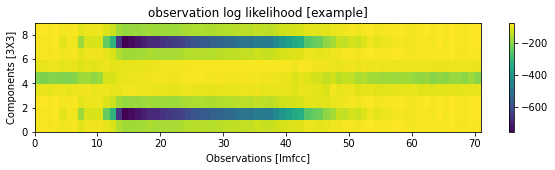

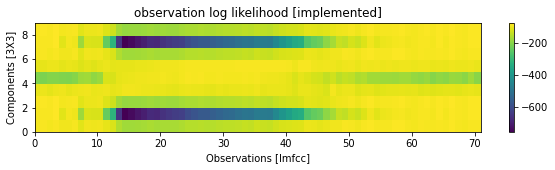

In [86]:
obsloglik_example = example['obsloglik']
fig, ax = plt.subplots(figsize=(10,2))
c = ax.pcolormesh(obsloglik_example.T,  vmin=np.min(obsloglik_example), vmax=np.max(obsloglik_example))
ax.set_title('observation log likelihood [example]')
ax.set_ylabel('Components [3X3]', color = "black")
ax.set_xlabel('Observations [lmfcc]', color = "black")
fig.colorbar(c, ax=ax)

fig, ax = plt.subplots(figsize=(10,2))
c = ax.pcolormesh(obsloglik_implemented.T,  vmin=np.min(obsloglik_implemented), vmax=np.max(obsloglik_implemented))
ax.set_title('observation log likelihood [implemented]')
ax.set_ylabel('Components [3X3]', color = "black")
ax.set_xlabel('Observations [lmfcc]', color = "black")
fig.colorbar(c, ax=ax)

it can be observed from the above, that the observations on the middle in the x-axis has a generally high lokLik for the middle compenents on the y-axis, those componentes correspond to the phonome '/o/'. The silence '/sil/' are in the first and last observations and their corresponding components are first and last compopents in the y-axis. Therefore, we observe a generally higher logLik in those areas. 

## Forward algorithm

In [0]:
float_epsilon = 2.22e-1000
startprob = wordHMMs['o']['startprob'] + float_epsilon
transmat = wordHMMs['o']['transmat'] + float_epsilon

In [88]:
alphas, logLikelihood = forward(example['obsloglik'], np.log(startprob), np.log(transmat))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [0]:
alphas_example = example['logalpha']

Check for equality

In [0]:
np.testing.assert_array_equal(alphas, alphas_example)

In [0]:
np.testing.assert_equal(logLikelihood, example['loglik'])

### Scoring all the 44 utterances

#### Utils functions

In [0]:
def score_likelihood(X, wordHMMs) :
    """
    X : is the observation from the lmfcc features Nframes X Ncoeeficients
        X = example['lmfcc'] 
    wordHMMs : is the word models of all the digits 
                ['o', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    """
    keys = list(wordHMMs.keys())
    wordsLogLikelihood = []
    
    for i in range(len(keys)) :
        covars = wordHMMs[keys[i]]['covars']
        means = wordHMMs[keys[i]]['means']
        float_epsilon = 2.22e-1000
        startprob = wordHMMs[keys[i]]['startprob'] + float_epsilon
        transmat = wordHMMs[keys[i]]['transmat'] + float_epsilon

        obsloglik_implemented = log_multivariate_normal_density_diag(X, means, covars)
        alphas, logLikelihood = forward(obsloglik_implemented, startprob, transmat)
        
        wordsLogLikelihood.append(logLikelihood)
        
    arg_max = np.argmax(wordsLogLikelihood)
    return wordsLogLikelihood, arg_max, keys[arg_max]

def evaluate_models_data(data, wordHMMs) :
    digits = []
    pred_digits = []
    genders = []
    for data_element in  data :
        digit = data_element['digit']
        X = data_element['lmfcc']
        gender = data_element['gender']
        digits.append(digit)
        genders.append(gender)
        wordsLogLikelihoods, index_digit, letter_digit  = score_likelihood(X, wordHMMs) 
        pred_digits.append(letter_digit)
        
    acc = accuracy_score(digits, pred_digits)
    print("accuracy : ", acc)
    print(genders)
    print(digits)
    print(pred_digits)
    return genders, digits, pred_digits, acc

In [0]:
def get_correctness(digits1, pred_digits1) :
    correctness = []
    for (x,y) in zip(digits1, pred_digits1) :
        if x == y :
            correctness.append(1)
        else :
            correctness.append(0.05)
    return correctness

In [0]:
def plotbar(values) :
    
    x_axis = np.arange(len(values))
    fig, ax = plt.subplots()
    plt.bar(x_axis, values)
    ax.set_xlabel('Utterances', color = "black", fontsize = 15)
    ax.set_ylabel('Correctness ', color = "black", fontsize = 15)
    title_obj = ax.set_title('Model evaluation')

#### Calculate all likelihood for 44 utterances

Simple model [one speaker]

In [95]:
phoneHMMs_all, phoneHMMs_oneSpeaker = read_phoneHMMs()
data = read_data()
prondict, isolated = pronounciation_dictionary()
wordHMMs = word_models(phoneHMMs_oneSpeaker, isolated)
genders1, digits1, pred_digits1, acc1 = evaluate_models_data(data, wordHMMs) 

accuracy :  0.4772727272727273
['man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman']
['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
['z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', '3', 'z', '4', '4', '3', '4', '3', '6', '3', '3', '3', '3', 'z', 'z', 'z', 'z', 'z', 'z', '1', 'z', '2', '2', '3', '3', '4', 'z', '4', '3', '6', '6', '7', '7', '8', '8', 'z', '9']


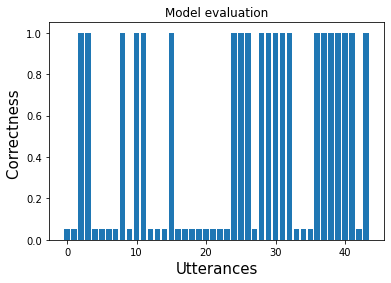

In [96]:
plotbar(get_correctness(digits1, pred_digits1))

Complex model [all speakers]

In [97]:
data = read_data()
prondict, isolated = pronounciation_dictionary()
wordHMMs = word_models(phoneHMMs_all, isolated)
genders2, digits2, pred_digits2, acc2 = evaluate_models_data(data, wordHMMs) 

accuracy :  0.8636363636363636
['man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman']
['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
['z', 'z', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', '1', '1', 'z', 'z', '1', '1', '2', '8', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '1', '9']


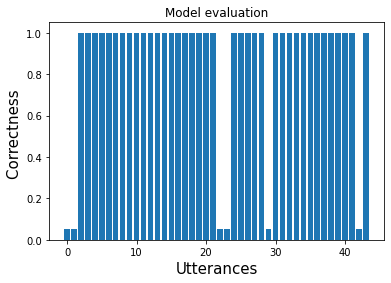

In [98]:
plotbar(get_correctness(digits2, pred_digits2))

There are much more mistaker in the model with one speaker compared wih that with several speakers. The accuracy in the first model is 0.77 and 0.97 in the second.

## Viterbi Approximation

### Drawing best Path for word 'o'

In [99]:
# viterbi test for word 'o'

log_emlik = example['obsloglik']
log_startprob = np.log(wordHMMs['o']['startprob'])
log_transmat = np.log(wordHMMs['o']['transmat'])
viterbi_loglik, viterbi_path = viterbi(log_emlik, log_startprob, log_transmat)

# comparing log likelihoods
print("Log likelihood for the example           :", example['vloglik'])
print("Log likelihood from the viterbi algorithm:", viterbi_loglik)

(71, 9)
Log likelihood for the example           : -5974.211288357338
Log likelihood from the viterbi algorithm: -5974.237978685437


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


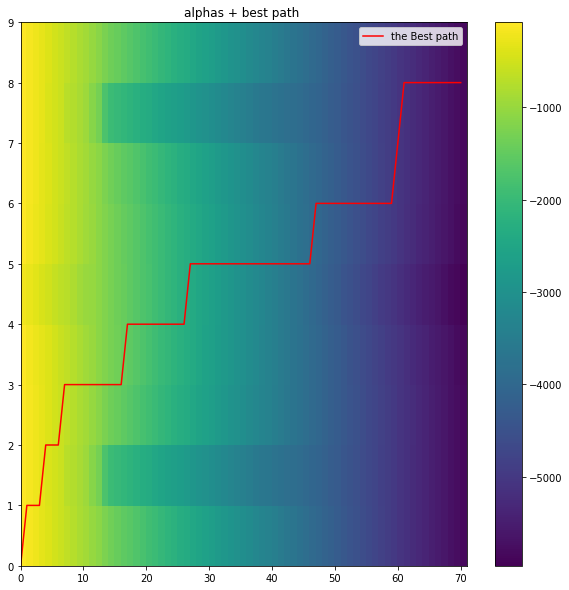

In [100]:
# drawing the best path 
log_startprob = wordHMMs['o']['startprob']
log_transmat = wordHMMs['o']['transmat']
log_emlik = example['obsloglik']
alphas, logLikelihood = forward(log_emlik, log_startprob, log_transmat)
fig, ax = plt.subplots(figsize=(10,10))
c = ax.pcolormesh(alphas.T)
plt.plot(np.arange(alphas.shape[0]), viterbi_path, 'r', label="the Best path")
ax.set_title('alphas + best path ')
fig.colorbar(c, ax=ax)
plt.legend()

Comments

We can see that the path us taking a sort of a 'stairs' shape, this is because the alphas gets monotonacly regressive (i.e the alphas are big in the left bottom but gets smaller the more we move to the top and right) and thus it is much likely to stay in a state for long when we are in teh region where the alphas are small than when we are in the region when the alphas are big, which explains the fats jumps in the bigenning and the slow progress when getting close to the end. 

### Evaluation

In [0]:
# scoring all 44 utterances

def viterbi_prediction(X, wordHMMs):
    viterbi_memo = []
    keys = list(wordHMMs.keys())
    for k in keys:
        covars = wordHMMs[k]['covars']
        means = wordHMMs[k]['means']    
        log_startprob = np.log(wordHMMs[k]['startprob'])
        log_transmat = np.log(wordHMMs[k]['transmat'])

        obsloglik = log_multivariate_normal_density_diag(X, means, covars)
        viterbi_loglik, _ = viterbi(obsloglik, log_startprob, log_transmat)
        viterbi_memo.append(viterbi_loglik)
        argmax = np.argmax(viterbi_memo)
    return viterbi_memo, argmax, keys[argmax]


def evaluate_viterbi(data, wordHMMs):
    digits = []
    pred_digits = []
    for data_element in  data :
        digit = data_element['digit']
        X = data_element['lmfcc']
        digits.append(digit)
        _, _, pred_digit  = viterbi_prediction(X, wordHMMs) 
        pred_digits.append(pred_digit)
    return digits, pred_digits

In [0]:
def get_correctness(digits1, pred_digits1) :
    correctness = []
    for (x,y) in zip(digits1, pred_digits1) :
        if x == y :
            correctness.append(1)
        else :
            correctness.append(0.05)
    return correctness

In [0]:
def plotbar(values) :
    x_axis = np.arange(len(values))
    fig, ax = plt.subplots()
    plt.bar(x_axis, values, color='g')
    ax.set_xlabel('Utterances', color = "grey", fontsize = 15)
    ax.set_ylabel('Correctness ', color = "grey", fontsize = 15)
    title_obj = ax.set_title('Model evaluation for viterbi')

In [0]:
# loading data
phoneHMMs_all, phoneHMMs_oneSpeaker = read_phoneHMMs()
data = read_data()
prondict, isolated = pronounciation_dictionary()

#### Simple Model \<One speaker\>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


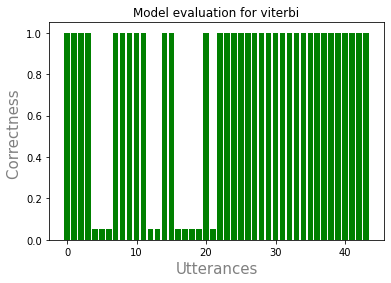

In [130]:
wordHMMs = word_models(phoneHMMs_oneSpeaker, isolated)
real, pred = evaluate_viterbi(data, wordHMMs)
plotbar(get_correctness(real, pred))

#### Complex model \<All speakers\>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


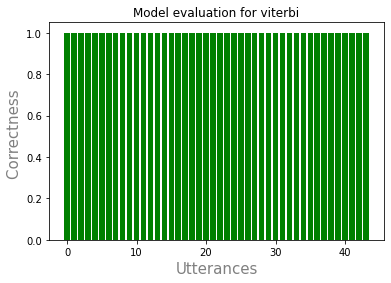

In [131]:
wordHMMs = word_models(phoneHMMs_all, isolated)
real, pred = evaluate_viterbi(data, wordHMMs)
plotbar(get_correctness(real, pred))

#### Comments
We can see that we a more complex model we don't get any wrong predictions, which is kind of intuitive. The simple model doesn't work as well since the model is very narrow and only models a female speaker. 

## Backward Algorithm


In [107]:
phoneHMMs_all, phoneHMMs_oneSpeaker = read_phoneHMMs()
example = read_example_data()
prondict, isolated = pronounciation_dictionary()
wordHMMs = word_models(phoneHMMs_oneSpeaker, isolated)

float_epsilon = 2.22e-1000
startprob = wordHMMs['o']['startprob'] + float_epsilon
transmat = wordHMMs['o']['transmat'] + float_epsilon
betas, logLikelihood_beta = backward(example['obsloglik'], np.log(startprob), np.log(transmat))

shape(betas) :  (71, 9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [103]:
example['loglik']

-5970.427602563561

In [104]:
logLikelihood_beta

-5844.975385828217

In [0]:
betas_example = example['logbeta']

betas and betas_example are equal up to 11 decimals !!

In [0]:
np.testing.assert_array_almost_equal(betas, betas_example, decimal=11)

## State posterior probabilities

### Verifying the probabilities (sum == 1)

In [144]:
example = read_example_data()
log_alpha = example['logalpha']
log_beta = example['logbeta']
log_gamma = statePosteriors(log_alpha, log_beta)

assert(np.any(np.sum(np.exp(log_gamma), axis=1) == 1) == True)
print(np.sum(np.exp(log_gamma), axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### GMM vs HMM

# New Section